In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import numpy as np 
import warnings
import shapely
import rasterio
from pathlib import Path
import os
import pandas as pd
from datetime import datetime
from netCDF4 import num2date, date2num, Dataset
from tqdm import tqdm
from scipy.ndimage import zoom
from joblib import Parallel, delayed
from pyproj import Proj, transform,Transformer

warnings.filterwarnings("ignore")
def read_gpkg(fnm,layer='perimeter'):
    ''' read gpkg data
    op: 'perimeter', 'fireline', 'newfirepix'
    '''

    gdf = gpd.read_file(fnm,layer=layer)

    return gdf

In [57]:
# Path to your GeoPackage file
gpkg_path = "Largefire/LargeFires_2020.gpkg"
weather_path = 'Weather/vs_2012.nc'
# List all layers in the GeoPackage
layers = fiona.listlayers(gpkg_path)
print("Layers in GeoPackage:", layers)

# List to hold the data from each file
dataframes = []
# Loop through each file and read the data
for file in Path.cwd().glob("Largefire/*.gpkg"):
    # Assuming you want to read the same layer from each GeoPackage
    # Replace 'your_layer_name' with the actual name of the layer you want to read
    if os.path.exists(file):
        gdf = gpd.read_file(file, layer='perimeter')
        dataframes.append(gdf)

# Combine all GeoDataFrames into one
combined_gdf = pd.concat(dataframes, ignore_index=True)


Layers in GeoPackage: ['perimeter', 'fireline', 'newfirepix']


In [74]:
fires = []
areas = []
for x in combined_gdf['fireID'].unique():
    fires.append(combined_gdf[combined_gdf['fireID'] == x]) 
for y in fires:
    areas.append(y['farea'].max())
avg = sum(areas) / len(areas)

In [75]:
# Define the projection of your current bounds (example: UTM Zone 15N)
proj_utm = Proj(init='epsg:32615')  # Replace 'epsg:32615' with the correct EPSG code

# Define the projection of your dataset (likely geographic coordinates)
proj_wgs84 = Proj(init='epsg:4326')
# Create a transformer object for converting from UTM to WGS84
transformer = Transformer.from_crs("epsg:32615", "epsg:4326", always_xy=True)

grid_size = 224  # 224x224 grid
total_pixels = grid_size ** 2  # Total number of pixels in the grid

# Assuming the area is in square degrees (modify this if the unit is different)
pixel_area = 500 / total_pixels / 250
pixel_size = np.sqrt(pixel_area)  # Since area = size^2
# pixel_size = 69.14668780499088

In [108]:
def adjust_bounds_to_fixed_resolution(df, pixel_size, grid_size=224):
    minx, miny, maxx, maxy = df.total_bounds

    # Calculate new spans based on pixel size and grid size
    new_lon_span = pixel_size * grid_size
    new_lat_span = pixel_size * grid_size

    # Center the new spans around the current center
    center_lon = (minx + maxx) / 2
    center_lat = (miny + maxy) / 2
    new_minx = center_lon - new_lon_span / 2
    new_maxx = center_lon + new_lon_span / 2
    new_miny = center_lat - new_lat_span / 2
    new_maxy = center_lat + new_lat_span / 2
    return new_minx, new_miny, new_maxx, new_maxy

def create_mesh_grid(minx, miny, maxx, maxy, grid_size=224):
    # Calculate the spans for longitude and latitude

    # Generate x and y coordinates
    x_coords = np.linspace(minx, maxx, grid_size)
    y_coords = np.linspace(miny, maxy, grid_size)

    # Create a mesh grid
    xx, yy = np.meshgrid(x_coords, y_coords)

    return xx, yy

def create_frames(df,grid):
    frames = []
    for index, shape in df.iterrows():
        geometry = shape['geometry']
        points = [geometry.contains(shapely.Point(x, y)) for x, y in zip(grid[0].ravel(), grid[1].ravel())]
        raster = np.array(points)
        raster = raster.reshape(grid[0].shape)
        frames.append(raster)
    return frames
def plot_selected_images(images_list):
    # Define the grid size for 20 images (e.g., 5x4)
    rows = 11
    cols = 10

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    # Iterate over the images and the axes to plot each image
    for ax, img in zip(axes.flatten(), images_list):
        ax.imshow(img,origin='lower', cmap='Reds')
        # ax.axis('off')  # Hide the axes

    plt.tight_layout()
    plt.show()
def extract_weather_frames(df, minx, miny, maxx, maxy, weather_path,wind_type, grid_size=224):
    nc_dataset = Dataset(weather_path, mode='r')
    days = nc_dataset.variables['day'][:]
    lon = nc_dataset.variables['lon'][:]
    lat = nc_dataset.variables['lat'][:]
    wind = nc_dataset.variables[wind_type][:]

    # Find the indices for the desired lon and lat range
    lon_idx = np.where((lon >= minx) & (lon <= maxx))[0]
    lat_idx = np.where((lat >= miny) & (lat <= maxy))[0]

    frames = []
    for _, row in df.iterrows():
        your_date = datetime.strptime(row['time'], '%Y-%m-%dT%H:%M:%S')
        reference_date = datetime.strptime('1900-01-01', '%Y-%m-%d')
        days_since_ref = (your_date - reference_date).days
        closest_day_index = np.abs(days - days_since_ref).argmin()

        # Slice using indices
        wind_speed_day = wind[closest_day_index, :, :]
        wind_speed_filtered = wind_speed_day[np.ix_(lat_idx, lon_idx)]

        # Resize
        zoom_factors = (grid_size / wind_speed_filtered.shape[0], grid_size / wind_speed_filtered.shape[1])
        wind_speed_resized = zoom(wind_speed_filtered, zoom_factors, order=1)

        frames.append(wind_speed_resized)

    nc_dataset.close()
    return frames

In [154]:
def process_fire(fire_file, speed_file, direction_file, pixel_size):
    gdf = gpd.read_file(fire_file, layer='perimeter')
    data = []
    for fire_id in gdf['fireID'].unique():
        fire = gdf[gdf['fireID'] == fire_id]
        minx, miny, maxx, maxy = adjust_bounds_to_fixed_resolution(fire, pixel_size)
        fires_frames = create_frames(fire, create_mesh_grid(minx, miny, maxx, maxy))
        wind_speed_frames = extract_weather_frames(fire, minx, miny, maxx, maxy, speed_file, "wind_speed")
        wind_direction_frames = extract_weather_frames(fire, minx, miny, maxx, maxy, direction_file, "wind_from_direction")
        data.append((fires_frames, wind_speed_frames, wind_direction_frames))
    return data

data = []

# Gather all file paths
fire_files = list(Path.cwd().glob("Largefire/*.gpkg"))
speed_files = list(Path.cwd().glob("Weather/vs*.nc"))
direction_files = list(Path.cwd().glob("Weather/th*.nc"))

# Check that we have an equal count of each file type
if not (len(fire_files) == len(speed_files) == len(direction_files)):
    print("Error: Unequal number of files in directories.")
else:
    # Parallel processing
    results = Parallel(n_jobs=6)(delayed(process_fire)(f, s, d, pixel_size) for f, s, d in zip(fire_files, speed_files, direction_files))

    # Flatten the list of results if necessary
    data = [item for sublist in results for item in sublist]

In [146]:
# data = []
# Loop through each file and read the data
# for fire_file,speed_file,direction_file in zip(Path.cwd().glob("Largefire/*.gpkg"),Path.cwd().glob("Weather/vs*.nc"),Path.cwd().glob("Weather/th*.nc")):
#     fires = []
#     if os.path.exists(fire_file) and os.path.exists(speed_file) and os.path.exists(direction_file):    
#         gdf = gpd.read_file(fire_file, layer='perimeter')
#         for x in gdf['fireID'].unique():
#             fires.append(gdf[gdf['fireID'] == x]) 
#     for idx,fire in enumerate(tqdm(fires)):
#         minx, miny, maxx, maxy = adjust_bounds_to_fixed_resolution(fire,pixel_size)
#         fires_frames = create_frames(fire,create_mesh_grid(minx, miny, maxx, maxy))
#         wind_speed_frames = extract_weather_frames(fire,minx, miny, maxx, maxy,speed_file,"wind_speed")
#         wind_direction_frames = extract_weather_frames(fire,minx, miny, maxx, maxy,direction_file,"wind_from_direction")
#         data.append((fires_frames,wind_speed_frames,wind_direction_frames))


  0%|          | 0/76 [00:00<?, ?it/s]

-122.33602846392168 39.31562501594748 -120.92181490154857 40.729838578320575
[array([[2.4       , 2.44439462, 2.48878924, ..., 2.87040359, 2.88520179,
        2.9       ],
       [2.42959641, 2.47180116, 2.51400591, ..., 2.87040359, 2.88520179,
        2.9       ],
       [2.45919283, 2.49920771, 2.53922259, ..., 2.87040359, 2.88520179,
        2.9       ],
       ...,
       [4.95919283, 5.01838565, 5.07757848, ..., 3.08002976, 3.06961129,
        3.05919283],
       [4.92959641, 4.98878924, 5.04798206, ..., 3.05481309, 3.04220475,
        3.02959641],
       [4.9       , 4.95919283, 5.01838565, ..., 3.02959641, 3.01479821,
        3.        ]]), array([[2.4       , 2.44439462, 2.48878924, ..., 2.87040359, 2.88520179,
        2.9       ],
       [2.42959641, 2.47180116, 2.51400591, ..., 2.87040359, 2.88520179,
        2.9       ],
       [2.45919283, 2.49920771, 2.53922259, ..., 2.87040359, 2.88520179,
        2.9       ],
       ...,
       [4.95919283, 5.01838565, 5.07757848, ..., 3

  4%|▍         | 3/76 [00:15<06:10,  5.08s/it]

[array([[174., 174., 174., ..., 311., 311., 311.],
       [174., 174., 174., ..., 311., 311., 311.],
       [174., 174., 174., ..., 311., 311., 311.],
       ...,
       [344., 344., 344., ..., 341., 341., 341.],
       [344., 344., 344., ..., 341., 341., 341.],
       [344., 344., 344., ..., 341., 341., 341.]]), array([[174., 174., 174., ..., 311., 311., 311.],
       [174., 174., 174., ..., 311., 311., 311.],
       [174., 174., 174., ..., 311., 311., 311.],
       ...,
       [344., 344., 344., ..., 341., 341., 341.],
       [344., 344., 344., ..., 341., 341., 341.],
       [344., 344., 344., ..., 341., 341., 341.]]), array([[166., 166., 166., ..., 156., 156., 156.],
       [166., 166., 166., ..., 156., 156., 156.],
       [166., 166., 166., ..., 156., 156., 156.],
       ...,
       [343., 343., 343., ..., 350., 350., 350.],
       [343., 343., 343., ..., 350., 350., 350.],
       [343., 343., 343., ..., 350., 350., 350.]]), array([[166., 166., 166., ..., 156., 156., 156.],
       

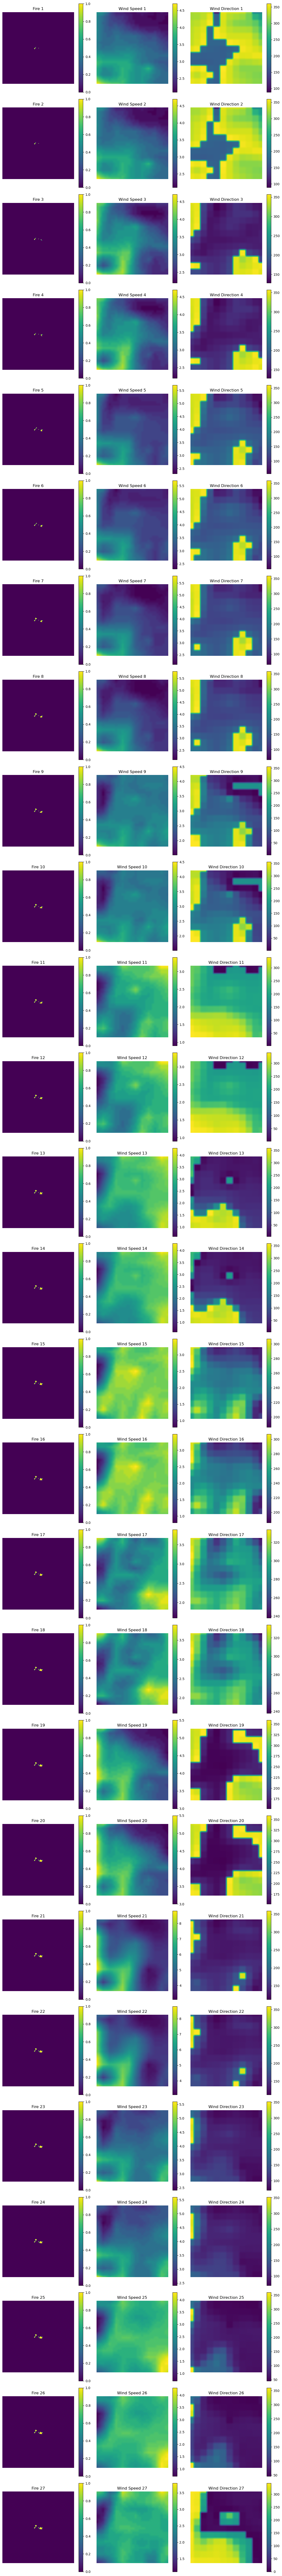

In [159]:

def plot_multiple_frames(frames1, frames2, frames3, title_prefixes=["Fire", "Wind Speed", "Wind Direction"]):
    # Assuming all frames lists are of the same length
    num_frames = len(frames1)

    # Create subplot layout
    n_cols = 3  # Three columns for three lists of frames
    n_rows = num_frames  # Each row will have one frame from each list

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

    for i in range(num_frames):
        for j, frames in enumerate([frames1, frames2, frames3]):
            ax = axs[i, j]
            im = ax.imshow(frames[i], cmap='viridis', origin='lower')
            ax.set_title(f"{title_prefixes[j]} {i+1}")
            ax.axis('off')
            fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()
plot_multiple_frames(data[10][0],data[10][1],data[10][2])

In [ ]:
# Specify the fireID you want to filter by
# specific_fireID = 3649
specific_fireID = 16
  # Replace with the fireID you are interested in

# Filter rows that match the specific fireID
filtered_gdf = (combined_gdf[combined_gdf['fireID'] == specific_fireID])

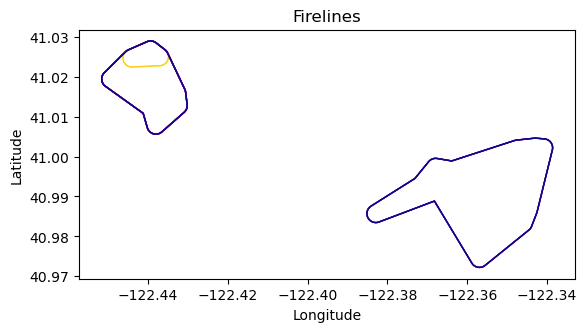

In [ ]:

# Create a color map
num_rows = len(filtered_gdf)
colors = plt.cm.plasma(np.linspace(0, 1, num_rows))[::-1]

# Plot each row with a different color
fig, ax = plt.subplots()
for i,(idx, row )in enumerate(filtered_gdf.iterrows()):
    row_gdf = gpd.GeoDataFrame([row], columns=filtered_gdf.columns)
    row_gdf.plot(ax=ax,edgecolor=colors[i],facecolor='none',label=f'Fireline {i+1}')
    

# Setting the title and labels
ax.set_title('Firelines')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [160]:
import pickle

with open('fire_frames_with_external_fata.pkl', 'wb') as f:
    pickle.dump(data, f)


In [ ]:
import pickle

with open('fire_frames.pkl', 'wb') as f:
    pickle.dump(frames, f)

new_frames = None
with open('fire_frames.pkl', 'rb') as f:
    new_frames = pickle.load(f)

plot_selected_images(new_frames)


NameError: name 'frames' is not defined

In [ ]:
with open('fire_frames.pkl', 'rb') as f:
    new_frames = pickle.load(f)



In [ ]:

# Open the NetCDF file
nc_dataset = Dataset('Weather/th_2012.nc', mode='r')

# Print all variable names
print("Variables in the NetCDF file:")
for var in nc_dataset.variables:
    print(var)

# Close the file
nc_dataset.close()

Variables in the NetCDF file:
lon
lat
day
crs
wind_from_direction


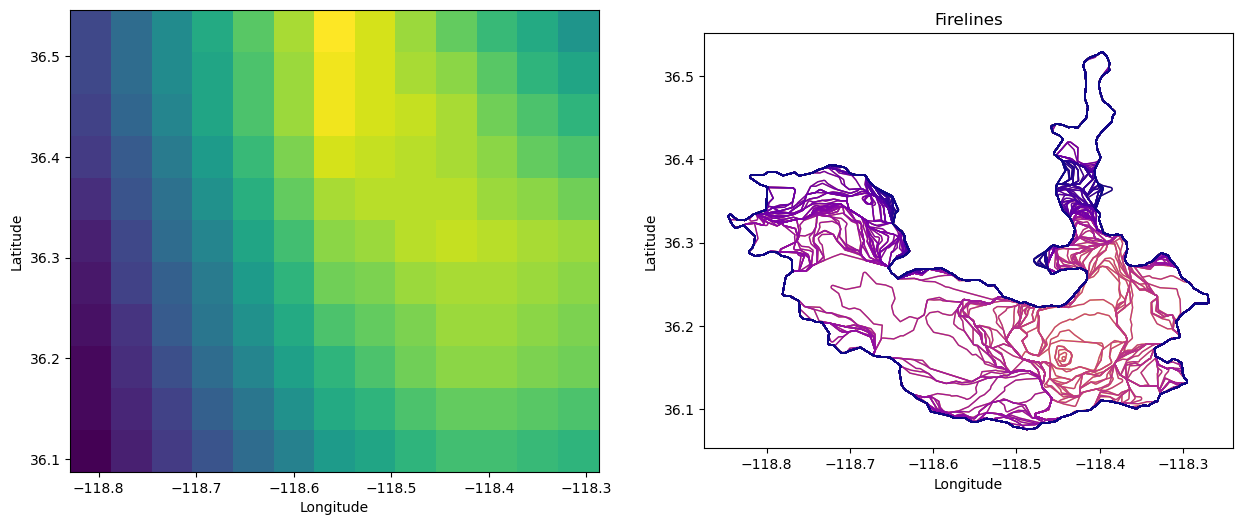

In [ ]:
your_date = datetime.strptime(filtered_gdf['time'].iloc[1], '%Y-%m-%dT%H:%M:%S')  # Example date in YYYY-MM-DD format
reference_date = datetime.strptime('1900-01-01', '%Y-%m-%d')
days_since_ref = (your_date - reference_date).days

# Load the 'day' variable from the NetCDF file
nc_dataset = netCDF4.Dataset(nc_file_path, mode='r')
days = nc_dataset.variables['day'][:]

# Find the index of the closest day
closest_day_index = np.abs(days - days_since_ref).argmin()


# Extracting longitude, latitude, and wind speed data
lon = nc_dataset.variables['lon'][:]
lat = nc_dataset.variables['lat'][:]
wind_speed = nc_dataset.variables['wind_speed'][:]  # Assuming wind_speed has a day dimension

# Specify the day you are interested in
specific_day_index = 0  # Replace with the index of the day you want to plot

# Extract wind speed data for the specific day
wind_speed_day = wind_speed[closest_day_index, :, :]

# Close the NetCDF file
nc_dataset.close()

# Create boolean masks for filtering
lon_mask = (lon >= minx) & (lon <= maxx)
lat_mask = (lat >= miny) & (lat <= maxy)

# Filter the wind speed data
wind_speed_filtered = wind_speed_day[np.ix_(lat_mask, lon_mask)]

# Plot wind speed data on the first subplot
# Create a meshgrid for plotting
lon_filtered = lon[lon_mask]
lat_filtered = lat[lat_mask]
LON, LAT = np.meshgrid(lon_filtered, lat_filtered)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting
axs[0].pcolormesh(LON, LAT, wind_speed_filtered, shading='auto')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
# Create a color map
num_rows = len(filtered_gdf)
colors = plt.cm.plasma(np.linspace(0, 1, num_rows))[::-1]

# Plot each row with a different color
for i,(idx, row )in enumerate(filtered_gdf.iterrows()):
    row_gdf = gpd.GeoDataFrame([row], columns=filtered_gdf.columns)
    row_gdf.plot(ax=axs[1],edgecolor=colors[i],facecolor='none',label=f'Fireline {i+1}')
    

# Setting the title and labels
axs[1].set_title('Firelines')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
plt.show()

In [ ]:
landcover_file = "/Users/jmacshane/Downloads/usa_land_cover_2020_30m_tif/ASK_NALCMS_landcover_2020_30m/data/ASK_NALCMS_landcover_2020_30m.tif"

In [ ]:
from PIL import Image
from rasterio.windows import Window

min_x, min_y, max_x, max_y = 100, 100, 300, 300

with rasterio.open(landcover_file) as src:
    # Calculate the window position
    window = Window.from_slices((min_y, max_y), (min_x, max_x))

    # Read the data from the window
    cropped_image = src.read(window=window)

    # Save the cropped image to a new file
    with rasterio.open(
        'cropped_image.tif', 
        'w', 
        driver='GTiff',
        height=window.height,
        width=window.width,
        count=src.count,
        dtype=src.dtypes[0],
        crs=src.crs,
        transform=src.window_transform(window)
    ) as dst:
        dst.write(cropped_image)
